# Hand-selected Representations


## Setup

### Load modules

In [352]:
import sys

import cmocean.cm
import datacube
import geopandas as gpd
import matplotlib.animation
import matplotlib.colors
import matplotlib.patches
import numpy as np
import scipy.cluster
import scipy.ndimage.filters
import sklearn.cluster
import sklearn.decomposition
import sklearn.pipeline
import sklearn.preprocessing
import statsmodels.tsa.stattools
import statsmodels.tsa.seasonal
from matplotlib import pyplot as plt
from scipy import optimize as opt
from tqdm.notebook import tqdm
import pandas as pd
import h5py
import seaborn

sys.path.insert(1, "../Scripts")
import dea_plotting

%matplotlib inline

### Load the data

This was generated in LoadWaterbodies.ipynb.

In [284]:
# basin = 'Carpentaria Coast'
# subbasin = 'MITCHELL RIVER (WA)'

basin = 'Murray-Darling Basin'
subbasin = 'BORDER RIVERS'

In [285]:
waterbodies_ = gpd.read_file('waterbodies_joined_drainage_basins.shp').to_crs('EPSG:3577')

In [286]:
waterbodies = waterbodies_.set_index('UID')

In [287]:
waterbodies.loc[pd.isnull(waterbodies.BNAME), 'BNAME'] = 'NONE'

In [288]:
waterbodies = waterbodies[(waterbodies.BNAME == subbasin) & (waterbodies.Division_ == basin)]

In [289]:
history_file = h5py.File('interpolated_waterbodies_by_division_and_basin.h5', mode='r')

In [290]:
dates = pd.to_datetime([l.decode('ascii') for l in history_file['dates']])

In [291]:
data = history_file[basin][subbasin]['pc_wet'][()]
mean = data.mean(axis=0)

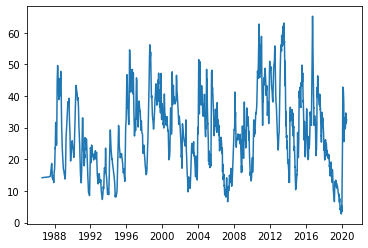

In [292]:
plt.plot(dates, mean)

## Seasonal decomposition

There are three components of these time series: trend, season, and everything else. A STL decomposition will split these out and we can analyse them separately.

In [293]:
stl = statsmodels.tsa.seasonal.STL(mean, period=365, seasonal=31)
stl_results = stl.fit()

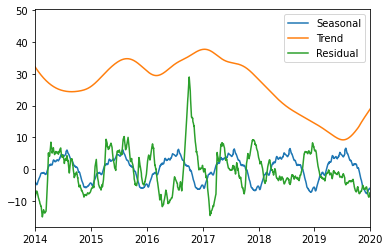

In [295]:
plt.plot(dates, stl_results.seasonal, label='Seasonal')
plt.plot(dates, stl_results.trend, label='Trend')
plt.plot(dates, stl_results.resid, label='Residual')
plt.xlim(pd.to_datetime('2014'), pd.to_datetime('2020'))
plt.legend()

Unfortunately the `statsmodels` implementation is pretty slow for large datasets. We can do something rather similar by taking a moving average ourselves across all the data for the trend, seasonal, and residual.

In [296]:
df = pd.DataFrame(data.T)
yearly_rolling_average = df.rolling(365, center=True, min_periods=1).mean()

In [297]:
trend = yearly_rolling_average.values.T

In [298]:
detrended = df - yearly_rolling_average

In [299]:
detrended.values.shape

(12391, 4417)

In [300]:
period = 365
period_averages = np.array([np.nanmean(detrended.values[i::period], axis=0) for i in range(period)])
seasonal = np.tile(period_averages.T, detrended.values.shape[0] // period + 1).T[:detrended.values.shape[0]]

In [301]:
deseasoned = detrended - seasonal

In [302]:
trend = yearly_rolling_average.values.T
residual = deseasoned.values.T

In [303]:
seasonal = seasonal.T

Without this decomposition it's really hard to figure out what's actually important in our data.

## Power spectrum features

We want to characterise the impulses. This means that we can't really use something in the time domain. We could autocorrelate the function or perhaps look at the power spectrum. Let's do that for the mean as well as its STL components.

In [304]:
mean_fft = scipy.fftpack.fftshift(scipy.fftpack.fft(mean))
season_fft = scipy.fftpack.fftshift(scipy.fftpack.fft(stl_results.seasonal))
trend_fft = scipy.fftpack.fftshift(scipy.fftpack.fft(stl_results.trend))
resid_fft = scipy.fftpack.fftshift(scipy.fftpack.fft(stl_results.resid))

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


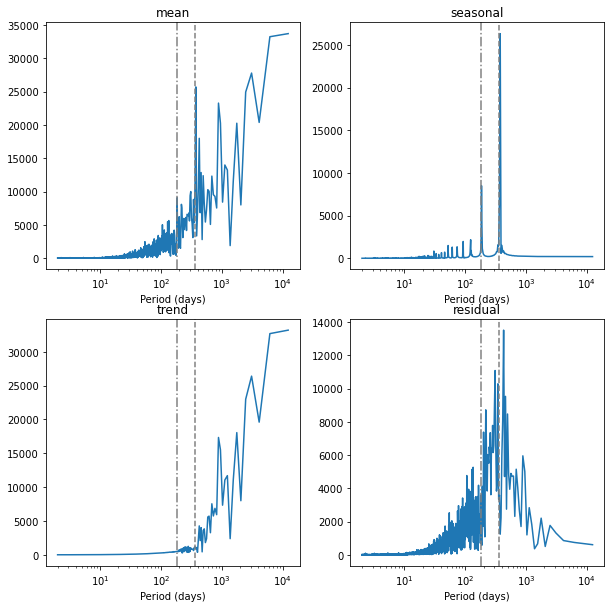

In [305]:
ffts = [mean_fft, season_fft, trend_fft, resid_fft]
names = ['mean', 'seasonal', 'trend', 'residual']
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    xs = np.arange(0, len(mean) // 2) / (len(mean))
    period = 1 / xs
    os_fft = abs(ffts[i])[len(ffts[i]) // 2 :][1:]
    plt.plot(period, os_fft)
    plt.xscale("log")
    plt.axvline(365, c="grey", linestyle="--")
    plt.axvline(365 / 2, c="grey", linestyle="-.")
    plt.xlabel("Period (days)")
    plt.title(names[i])

(Note that this decomposition is also additive since the FFT is linear!)

In [306]:
year_idx = np.argmin(abs(period - 365))

In [308]:
period[year_idx]

364.44117647058823

The power spectrum (at least of the mean) is meaningful. The peak is simply the yearly monsoons, which is most clear in the seasonal FFT. Let's see what the peak is for slightly less regular waterbodies.

In [309]:
mean_fft = scipy.fftpack.fftshift(scipy.fftpack.fft(data))
season_fft = scipy.fftpack.fftshift(scipy.fftpack.fft(seasonal))
trend_fft = scipy.fftpack.fftshift(scipy.fftpack.fft(trend))
resid_fft = scipy.fftpack.fftshift(scipy.fftpack.fft(residual))

375.48484848484844
375.48484848484844
375.48484848484844
375.48484848484844
375.48484848484844
375.48484848484844
375.48484848484844
375.48484848484844
375.48484848484844


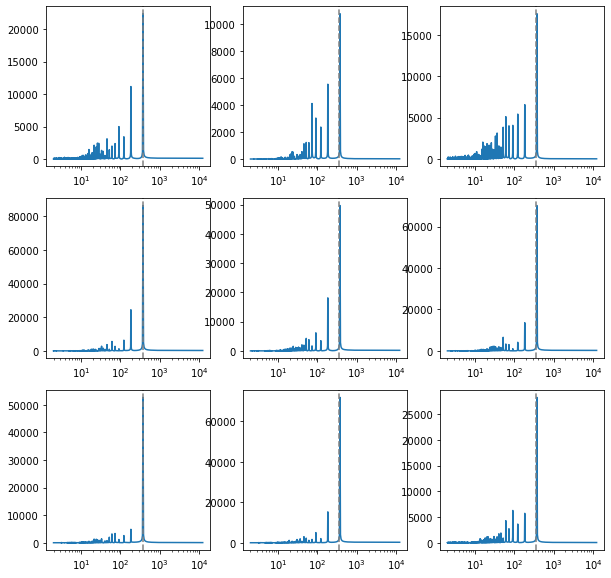

In [311]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    ys = abs(season_fft[i])[len(season_fft[i]) // 2 + 1 :]
    plt.plot(period, ys)
    print(period[ys.argmax()])
    plt.xscale("log")
    plt.axvline(365, c="grey", linestyle="--")

In [312]:
year_peaks = [abs(s).argmax() for s in season_fft]

There seem to be some lower-frequency components that don't really make sense to me. This probably comes from dry periods... We could definitely characterise the signal by how strong the yearly peak is though (as a percentage of total power?).

In [313]:
year_peak = np.bincount(year_peaks).argmax()

In [314]:
year_power = abs(mean_fft)[:, year_peak]
year_power_relative = year_power / np.sum(abs(mean_fft)[:, year_peak])

Is the phase meaningful here?

In [376]:
year_phase = np.angle(season_fft)[:, year_peak]

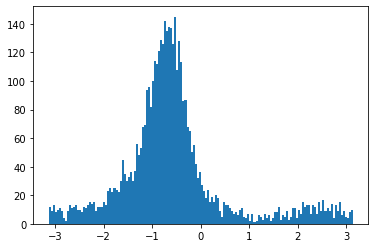

In [377]:
plt.hist(year_phase, bins=150);

Perhaps the phase indicates the time when the peak occurs.

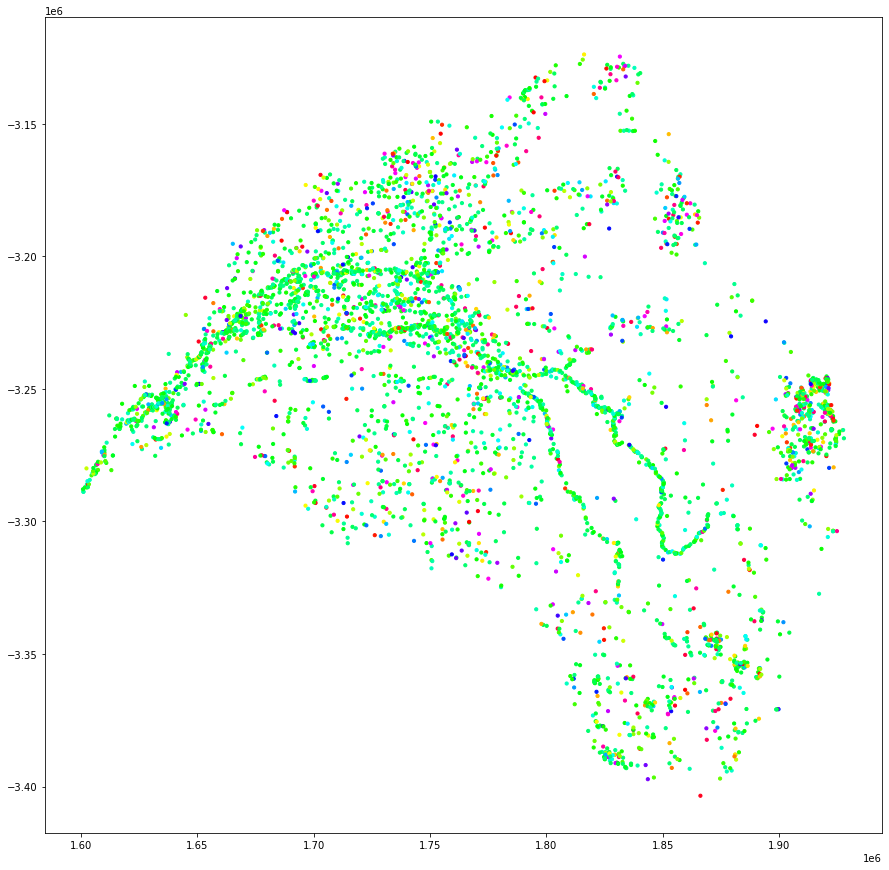

In [378]:
plt.figure(figsize=(15, 15))
plt.scatter(
    waterbodies.centroid.x,
    waterbodies.centroid.y,
    c=year_phase,
    cmap='hsv',
    s=10,
);

This seems to be spatially correlated, which is what we'd expect if I'm right.

In [318]:
xs = waterbodies.centroid.x
ys = waterbodies.centroid.y

In [319]:
import mattplot

In [336]:
sine_avg = mattplot.spatial_average(xs, ys, np.sin(year_phase), k=10)
cosine_avg = mattplot.spatial_average(xs, ys, np.cos(year_phase), k=10)
naive_avg = mattplot.spatial_average(xs, ys, year_phase, k=10)

In [337]:
angle_avg = np.arctan2(cosine_avg, sine_avg)

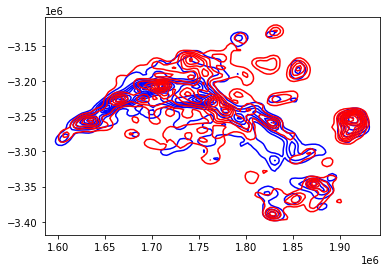

In [368]:
mask = (year_phase > -1) & (year_phase < 0)
seaborn.kdeplot(xs[mask], ys[mask], gridsize=100, bw=5000, colors='blue')
mask = (year_phase > 0)
seaborn.kdeplot(xs[mask], ys[mask], gridsize=100, bw=5000, colors='red')

Wow, that's really something! Leo suggests this is the groundwater connectivity. This looks like an excellent feature.

Note: It seems way more meaningful in the far north than in the MDB.

## Permanence

A third feature we can use is the non-zero percentage, which tells us the permanence of the waterbody:

In [369]:
nonzero_percentage = (data > 0).mean(axis=1)

And maybe just the more recent percentages too (in case there are dams built after 1986, for example).

In [370]:
nonzero_percentage_recent = (data[:, -365 * 5 :] > 0).mean(axis=1)

We can also grab how often it is _totally_ (or near-totally) full.

In [371]:
full_percentage = (data > 0.99).mean(axis=1)
full_percentage_recent = (data[:, -365 * 5 :] > 0.99).mean(axis=1)

Perhaps also the first time water was observed?

In [372]:
first_occurrence = data.argmin(axis=1)

## Surface area duration curves

Let's make some surface area duration curves, which should describe how often each waterbody is full and how rapidly it empties.

In [380]:
sadc = np.sort(data, axis=1)[:, ::-1]

In [407]:
sadc_seasonal = np.sort(seasonal, axis=1)[:, ::-1]

In [410]:
sadc_trend = np.sort(trend, axis=1)[:, ::-1]

In [412]:
sadc_resid = np.sort(residual, axis=1)[:, ::-1]

Text(0, 0.5, 'Surface area (seasonal)')

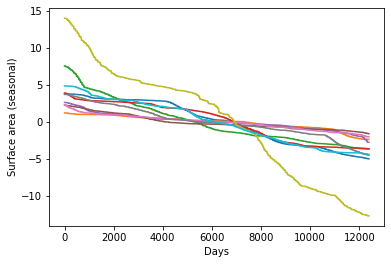

In [409]:
plt.figure()
plt.plot(sadc_seasonal[:10].T)
plt.xlabel("Days")
plt.ylabel("Surface area (seasonal)")

Text(0, 0.5, 'Surface area (trend)')

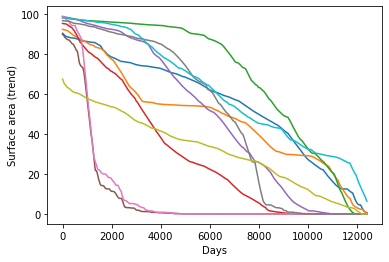

In [411]:
plt.figure()
plt.plot(sadc_trend[:10].T)
plt.xlabel("Days")
plt.ylabel("Surface area (trend)")

Text(0, 0.5, 'Surface area (residual)')

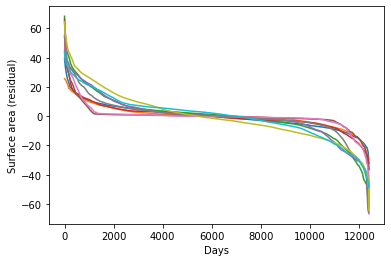

In [413]:
plt.figure()
plt.plot(sadc_resid[:10].T)
plt.xlabel("Days")
plt.ylabel("Surface area (residual)")

Text(0, 0.5, 'Surface area')

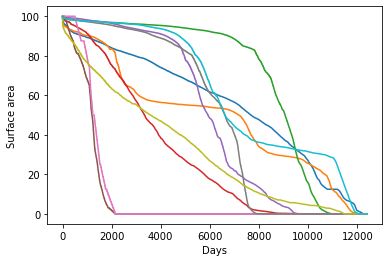

In [381]:
plt.figure()
plt.plot(sadc[:10].T)
plt.xlabel("Days")
plt.ylabel("Surface area")

I guess we really care about the gradient here. We already know how often the waterbody is full and empty. We should somehow look at just the period where it is emptying...

This is a tyre fire without smoothing, so a yearly sigma will do the trick to smooth that gradient right out. Such a long sigma is justified by the fact we're evaluating this over 12000 days: we really really do not care about small scale things. This is super slow though, so we'll subsample first. Also, all months are February now.

In [384]:
sadc_smooth = scipy.ndimage.filters.gaussian_filter1d(sadc.astype(float)[:, ::28], axis=1, sigma=12)
sadc_grad = np.gradient(sadc_smooth, axis=1)

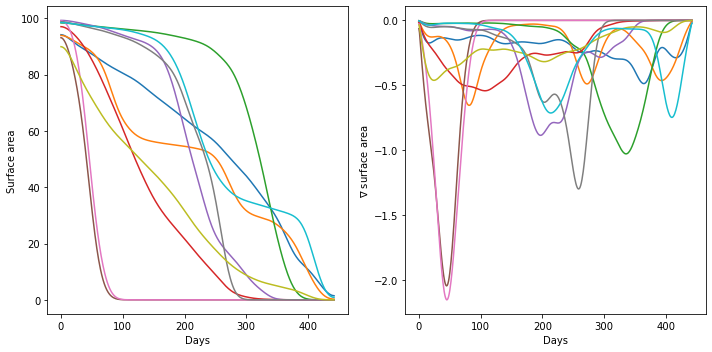

In [387]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(sadc_smooth[:10].T)
plt.xlabel("Days")
plt.ylabel("Surface area")
# plt.xlim(0, 4000)
plt.subplot(1, 2, 2)
plt.plot(sadc_grad[:10].T)
plt.xlabel("Days")
plt.ylabel("$\\nabla$ surface area")
# plt.xlim(0, 4000)
plt.tight_layout()

In [388]:
sadc_emptying = []
for s in tqdm(sadc_smooth):
    full = s == 1
    empty = s == 0
    emptying = s[~full & ~empty]
    sadc_emptying.append(emptying)

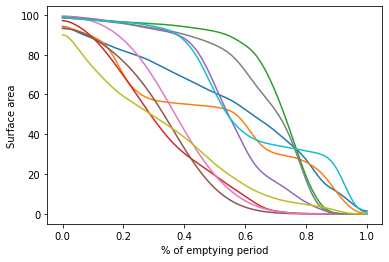

In [389]:
plt.figure()
for i in range(10):
    plt.plot(np.linspace(0, 1, len(sadc_emptying[i])), sadc_emptying[i])
    plt.xlabel("% of emptying period")
    plt.ylabel("Surface area")

In [390]:
sadc_emptying_interp = []
for s in sadc_emptying:
    interp = np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, len(s)), s)
    sadc_emptying_interp.append(interp)
sadc_emptying_interp = np.array(sadc_emptying_interp)

In [391]:
sadc_emptying_interp_grad = np.gradient(sadc_emptying_interp, axis=1)

Text(0, 0.5, '$\\nabla$ surface area')

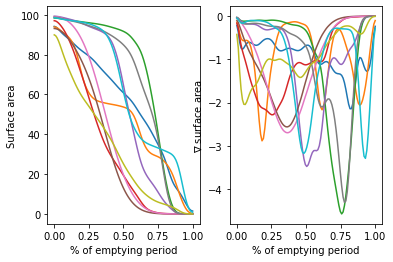

In [392]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, 1, 100), sadc_emptying_interp[:10].T)
plt.xlabel("% of emptying period")
plt.ylabel("Surface area")
plt.subplot(1, 2, 2)
plt.plot(np.linspace(0, 1, 100), sadc_emptying_interp_grad[:10].T)
plt.xlabel("% of emptying period")
plt.ylabel("$\\nabla$ surface area")

With the smoothing in place we can now see the gradient much more easily. Things we can ask about this include "when is the gradient steepest?" and "how steep is the gradient?". We could also ask if the gradient is bimodal, etc. What about the average of the gradient, or the average of the surface area?

In [393]:
gradient_peaks = [scipy.signal.find_peaks(abs(sg))[0] for sg in tqdm(sadc_emptying_interp_grad)]

In [394]:
n_peaks = [len(gp) for gp in gradient_peaks]

In [395]:
peak_locs = np.argmax(abs(sadc_emptying_interp_grad), axis=1)

In [396]:
peak_heights = np.max(abs(sadc_emptying_interp_grad), axis=1)

In [397]:
mean_grad = np.mean(sadc_emptying_interp_grad, axis=1)
mean_sadc = np.mean(sadc_emptying_interp, axis=1)

## PCA on our features

Let's evaluate our features by doing PCA on their normalised forms.

In [402]:
features = np.stack(
    [
        nonzero_percentage,
        nonzero_percentage_recent,
        np.sin(year_phase),
        np.cos(year_phase),
        year_phase,
        year_power,
        year_power_relative,
        n_peaks,
        peak_locs,
        peak_heights,
        mean_grad,
        mean_sadc,
        first_occurrence,
    ]
).T

In [403]:
pipeline = sklearn.pipeline.Pipeline(
    [
        ("scale", sklearn.preprocessing.StandardScaler()),
        ("pca", sklearn.decomposition.PCA(n_components=2)),
    ]
)
pca_f = pipeline.fit_transform(features)

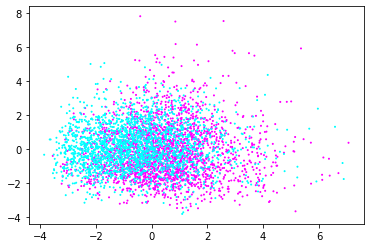

In [406]:
plt.figure()
plt.scatter(*pca_f.T, s=1, c=waterbodies.FEATURETYP == 'Farm Dam Area', cmap='cool')

We can also try a very naive t-SNE.

In [237]:
# tsne = sklearn.pipeline.Pipeline(
#     [
#         ("scale", sklearn.preprocessing.StandardScaler()),
#         ("tsne", sklearn.manifold.TSNE(early_exaggeration=35, perplexity=50, n_iter=10000, verbose=2)),
#     ]
# )
# tsne_f = tsne.fit_transform(features)

In [238]:
# plt.figure()
# plt.scatter(*tsne_f.T, s=1, c=polsby_popper)

## Basic prediction

To test our representations, let's try to predict the Polsby-Popper score for the waterbodies based on the features.

In [240]:
train_indices, test_indices, train_labels, test_labels, train_features, test_features = sklearn.model_selection.train_test_split(
    np.arange(len(data)),
    polsby_popper,
    features,
    test_size=0.2)

In [276]:
import sklearn.ensemble
prd = sklearn.ensemble.RandomForestRegressor()

In [277]:
prd.fit(train_features, train_labels)

RandomForestRegressor()

In [278]:
plt.figure()
plt.scatter(train_labels, prd.predict(train_features), s=1, label='train', alpha=0.5)
plt.scatter(test_labels, prd.predict(test_features), s=1, label='test')
plt.xlabel('Polsby-Popper score')
plt.ylabel('Predicted Polsby-Popper score')
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [279]:
prd.score(test_features, test_labels)

0.40065872583609885

How does this compare to using the histories directly?

In [292]:
prd_history = sklearn.ensemble.RandomForestRegressor()
prd_history.fit(data[train_indices][:, ::100], train_labels)

RandomForestRegressor()

In [293]:
prd_history.score(data[test_indices][:, ::100], test_labels)

0.3318533272166918

This is _super slow_ but does work surprisingly well.

In [53]:
yes_rivers = ['rjjkujrwt', 'rjjpt7xmv', 'rjjpunRandomForestRegressorn', 'rjkbk4x2f', 'rjk8m0d5r',
              'rjkezw9re', 'rjm5p0r3d']

In [54]:
no_rivers = ['rjhxjxn26', 'rjhxnz3eh', 'rjhueqyfw', 'rjhu5mysy']

In [55]:
import sklearn.ensemble
clf = sklearn.ensemble.RandomForestClassifier()

In [56]:
labels_pos = waterbodies.UID.isin(yes_rivers)
labels_neg = waterbodies.UID.isin(no_rivers)
labels_any = labels_pos | labels_neg

In [57]:
clf.fit(features[labels_any], labels_pos[labels_any])

RandomForestClassifier()

In [58]:
predictions = clf.predict_proba(features)[:, 1]

In [59]:
sum(predictions > 0.5)

3673

Let's active learn this!

In [60]:
import ipywidgets as w

In [61]:
dc = datacube.Datacube()

In [138]:
labels_any = labels_any.values

In [150]:
labels_pos = labels_pos.values.astype(bool)
labels_neg = labels_neg.values.astype(bool)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [151]:
labels_pos = labels_pos.astype(bool)
labels_neg = labels_neg.astype(bool)

In [159]:
import matplotlib.patches

def collect_labels():
    yes = []
    no = []
    has_labels = labels_any.copy()
    labels = np.zeros_like(labels_any)
    print(sum(has_labels), 'labels so far')
    labels[labels_pos] = True
    labels[labels_neg] = False
    
    clf = sklearn.ensemble.RandomForestClassifier()
    
    def get_new():
        # Retrain and then choose the middle-est non-labelled waterbody.
        clf.fit(features[has_labels], labels[has_labels])
        predictions = clf.predict_proba(features[~has_labels])[:, 1]
        middlest = np.argmin(abs(predictions - 0.5))
        # Map that back to a useful index.
        nonlabelled = (~has_labels).nonzero()[0][middlest]
        
        # Grab the geomedian.
        waterbody = waterbodies.iloc[nonlabelled]
        da = dc.load('ls8_nbart_geomedian_annual', measurements=['red', 'green', 'blue'],
                     geopolygon=datacube.utils.geometry.Geometry(waterbody.geometry.buffer(1500), crs='EPSG:3577'), time='2019-01')
        return nonlabelled, waterbody, da

    nonlabelled, waterbody, da = get_new()
    
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(1, 1, 1)
    dea_plotting.rgb(da.isel(time=0), bands=['red', 'green', 'blue'], ax=ax)
    geometry = waterbody.geometry
    patch = matplotlib.patches.Polygon(geometry.exterior, edgecolor='white', facecolor='#AAAAFF55')
    ax.add_patch(patch)
    waterbody_loc = gpd.GeoDataFrame([waterbody], crs='EPSG:3577').to_crs('EPSG:4326').centroid.iloc[0]
    ax.set_title('{} ({:.03f}, {:.03f})'.format(waterbody.UID, waterbody_loc.y, waterbody_loc.x))
    
    def do_label(v):
        nonlocal nonlabelled, waterbody, da
        has_labels[nonlabelled] = True
        labels[nonlabelled] = v
        
        # Relabel.
        
        # Then get a new waterbody.
        nonlabelled, waterbody, da = get_new()

        # Update the plot.
        ax.cla()
        dea_plotting.rgb(da.isel(time=0), bands=['red', 'green', 'blue'], ax=ax)
        geometry = waterbody.geometry
        patch = matplotlib.patches.Polygon(geometry.exterior, edgecolor='white', facecolor='#AAAAFF55')
        ax.add_patch(patch)
        waterbody_loc = gpd.GeoDataFrame([waterbody], crs='EPSG:3577').to_crs('EPSG:4326').centroid.iloc[0]
        ax.set_title('{} ({:.03f}, {:.03f})'.format(waterbody.UID, waterbody_loc.y, waterbody_loc.x))

    aye = w.Button(description='river', icon='check')
    nay = w.Button(description='not river', icon='times')
    aye.on_click(lambda _: do_label(True))
    nay.on_click(lambda _: do_label(False))
    return w.HBox([aye, nay]), labels, has_labels

#         ax = plt.subplot(3, 3, i + 1)
#         dea_plotting.rgb(das_1[i], bands=['red', 'green', 'blue'], ax=ax)
#         geometry = waterbodies.iloc[cluster_1_sample[i]].geometry
#         patch = matplotlib.patches.Polygon(geometry.exterior, edgecolor='white', facecolor='#AAAAFF55')
#         ax.add_patch(patch)
#         ax.set_title('')
#         ax.axis('off')
#         ys = data[cluster_1_sample[i]]
#         ys = ys / max(ys) * 0.5
#         xs = np.linspace(0, 1, len(ys))
#         points = np.stack([xs, ys]).T
#         tf_sp = ax.transData.inverted().transform(ax.transAxes.transform(points))
#         plt.plot(tf_sp[:, 0], tf_sp[:, 1], c='white')

In [160]:
widget, labels, has_labels = collect_labels()
widget

41 labels so far


/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [177]:
# Save labels into a persistent array
labels_pos[has_labels] |= labels[has_labels]
labels_neg[has_labels] |= ~labels[has_labels]
labels_any |= has_labels

In [178]:
clf = sklearn.ensemble.RandomForestClassifier()

In [179]:
clf.fit(features[has_labels], labels[has_labels])

RandomForestClassifier()

In [180]:
predictions = clf.predict_proba(features)[:, 1]

In [181]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(*tsne_f.T, s=1, c=predictions, cmap='cool')
plt.scatter(*tsne_f[has_labels].T, c=predictions[has_labels], marker='x', cmap='cool', s=20)
plt.subplot(1, 2, 2)
plt.scatter(*tsne_f.T, s=1, c=gpd.pd.notnull(waterbodies.Stream), cmap='cool')

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [166]:
plt.figure()
plt.hist(polsby_popper[predictions > 0.5], density=True, label='rivery')
plt.hist(polsby_popper[predictions < 0.5], density=True, alpha=0.5, label='not rivery')
plt.xlabel('Polsby-Popper')
plt.ylabel('Density')
plt.legend()

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [168]:
plt.figure()
sads_river = sadc[predictions > 0.5]
sads_notriver = sadc[predictions < 0.5]

plt.plot(sads_river.mean(axis=0), label='rivery')
plt.plot(sads_notriver.mean(axis=0), label='not rivery')

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Surface curve off the main channel:

In [115]:
wbuid = waterbodies.set_index('UID')

In [127]:
plt.figure()
plt.plot(sadc[wbuid.index.get_loc('rjjs3q986')], label='Windermere Lagoon')
plt.plot(sadc[wbuid.index.get_loc('rjjs9gkgy')], label='Palmer River')
plt.plot(sadc[wbuid.index.get_loc('rjjesmg8r')], label='Mitchell River')
plt.plot(sadc[wbuid.index.get_loc('rjjs6wcxc')], label='some random pond I found')
plt.legend()

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …